In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/0664.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/1269.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/3863.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/2193.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/0733.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/3750.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/2008.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/2081.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/0106.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/0375.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/3919.jpg
/kaggle/input/lung-cancer-histopathological-images/squamous_cell_carcinoma/3

In [2]:


import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import os
import seaborn as sns
#import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join

from scipy import misc
from random import shuffle
from collections import Counter

import tensorflow as tf
from tensorflow.keras import models,layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Input



In [3]:
ds_train=tf.keras.preprocessing.image_dataset_from_directory(r'/kaggle/input/lung-cancer-histopathological-images/',subset='training',validation_split=0.2,seed=1)
ds_test=tf.keras.preprocessing.image_dataset_from_directory(r'/kaggle/input/lung-cancer-histopathological-images/',subset='validation',validation_split=0.2,seed=1)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


In [4]:


class_names=ds_train.class_names
class_names



['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

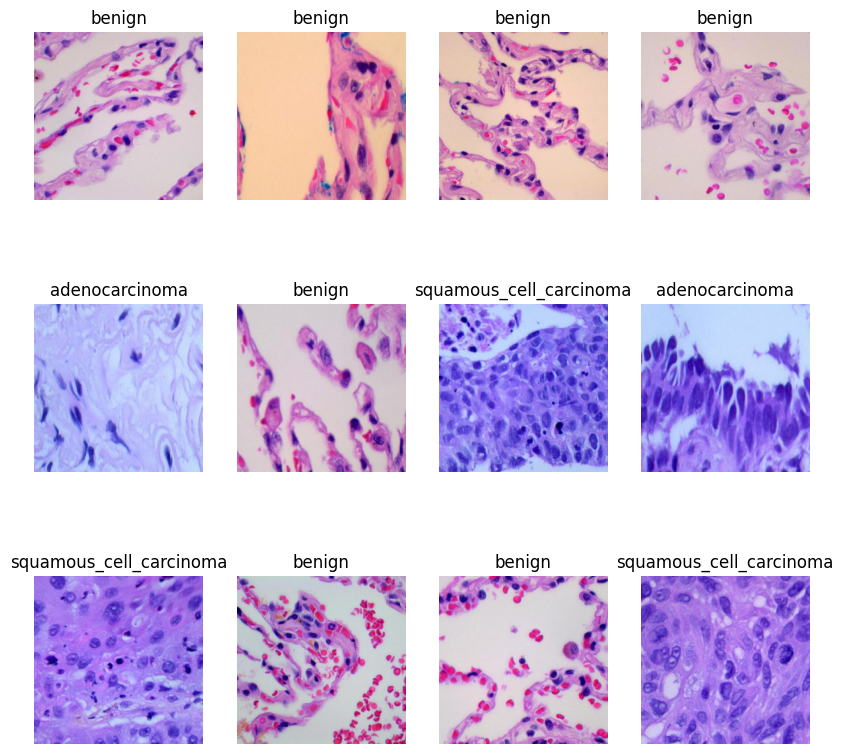

In [5]:


plt.figure(figsize=(10,10))
for image_batch,labels_batch in ds_train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")



In [6]:
!pip install split-folders
import numpy as np
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Flatten, Lambda,GlobalAveragePooling2D,Reshape,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda
import tensorflow as tf


In [7]:
# Define the input shape of the images
input_shape = (256, 256, 3)

# Define the number of classes
num_classes = 3

# Define the batch size and number of epochs
batch_size = 32
epochs = 55

# Define the data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
input_folder = '/kaggle/input/lung-cancer-histopathological-images/'
splitfolders.ratio(input_folder, output="/kaggle/working/", 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None) # default values
train_generator = train_datagen.flow_from_directory('/kaggle/working/train',
                                                    target_size=input_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory('/kaggle/working/val',
                                                    target_size=input_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Copying files: 15000 files [02:21, 106.18 files/s]


Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [8]:


from keras.applications.resnet import ResNet50

# load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:


# Add new top layers for our specific classification problem
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
resnet50_model = Model(inputs=base_model.input, outputs=x)



In [10]:
# Compile the model
resnet50_model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])


In [11]:


import time

start = time.time()

resnet50_history = resnet50_model.fit(train_generator,
                    epochs=25,
                    validation_data=valid_generator,
                    verbose=1)

print("Training accuracy:", resnet50_history.history['accuracy'][-1])
print("Validation accuracy:", resnet50_history.history['val_accuracy'][-1])

end = time.time()
print(end - start)

# Save the model
resnet50_model.save('lung_model.h5')



Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 541ms/step - accuracy: 0.4556 - loss: 7.1417 - val_accuracy: 0.7787 - val_loss: 0.6113
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 199s 522ms/step - accuracy: 0.6690 - loss: 0.8677 - val_accuracy: 0.7827 - val_loss: 0.5592
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 199s 520ms/step - accuracy: 0.7652 - loss: 0.5560 - val_accuracy: 0.7007 - val_loss: 0.7352
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 199s 522ms/step - accuracy: 0.7835 - loss: 0.5095 - val_accuracy: 0.7993 - val_loss: 0.4677
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 519ms/step - accuracy: 0.7869 - loss: 0.4833 - val_accuracy: 0.7920 - val_loss: 0.5078
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 517ms/step - accuracy: 0.7912 - loss: 0.4718 - val_accuracy: 0.8313 - val_loss: 0.3673
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 196s 514ms/step - accuracy: 0.8130 - loss: 0.4327 - val_accuracy: 0.8720 - val_loss: 0.3254
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 200s 523ms/step - accuracy: 0.8107 - loss: 0.44

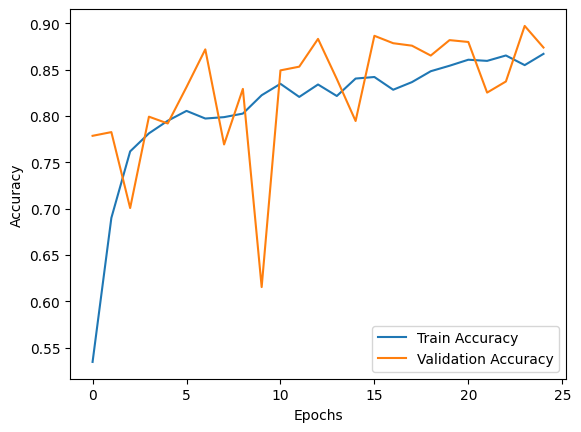

In [12]:


def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(resnet50_history)



In [15]:
# Predict probabilities
y_pred_probs = resnet50_model.predict(valid_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = valid_generator.classes

# Get class names (in order)
class_names = list(valid_generator.class_indices.keys())


47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step


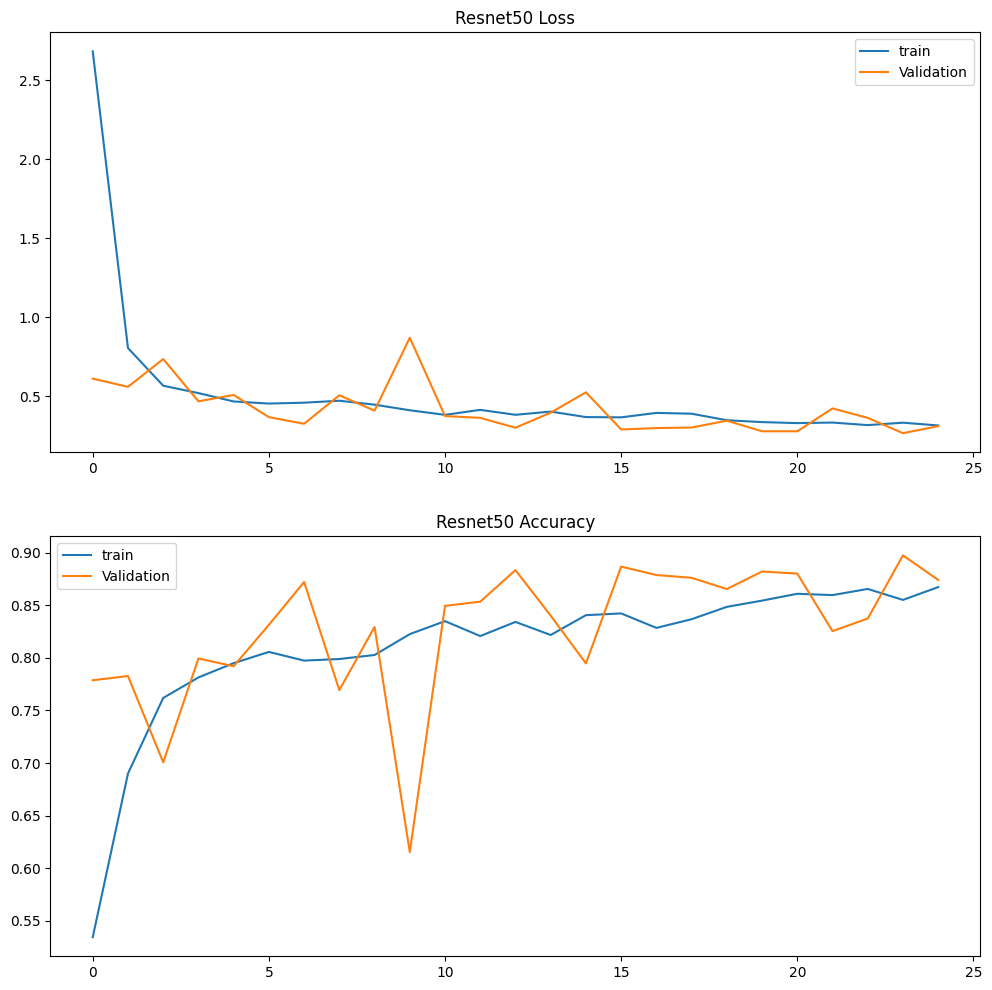

In [16]:


plt.figure(figsize=(12,12))
# plot loss during training
plt.subplot(211)
plt.title('Resnet50 Loss')
plt.plot(resnet50_history.history['loss'], label='train')
plt.plot(resnet50_history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Resnet50 Accuracy')
plt.plot(resnet50_history.history['accuracy'], label='train')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()



In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


In [19]:
# Predict class probabilities
y_score = resnet50_model.predict(valid_generator)

# True labels (as integers)
y_true = valid_generator.classes

# Class names
class_names = list(valid_generator.class_indices.keys())
n_classes = len(class_names)

# Binarize the true labels (e.g., [0, 1, 2] → [[1, 0, 0], [0, 1, 0], [0, 0, 1]])
y_true_bin = label_binarize(y_true, classes=range(n_classes))



47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step


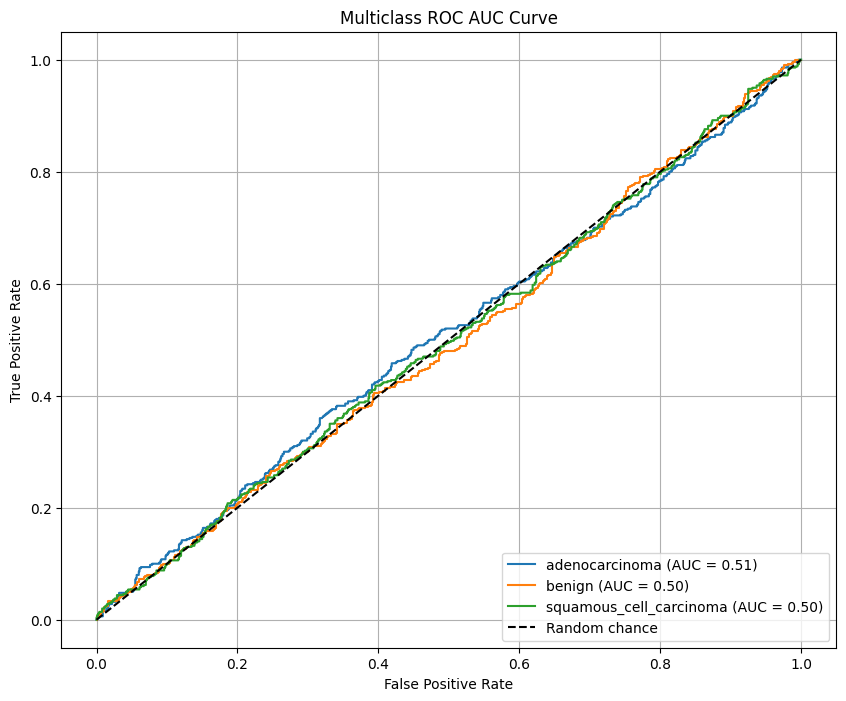

In [20]:
# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC AUC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import classification_report
import numpy as np
model=resnet50_model
# Step 1: Predict on the test data
# Assuming test_generator is defined (like ImageDataGenerator.flow_from_directory)
y_pred_probs = model.predict(valid_generator)

# Step 2: Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Get true class indices
y_true = valid_generator.classes

# Step 4: Get class names
class_names = list(valid_generator.class_indices.keys())

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step
                         precision    recall  f1-score   support

         adenocarcinoma       0.34      0.38      0.36       500
                 benign       0.32      0.29      0.30       500
squamous_cell_carcinoma       0.34      0.34      0.34       500

               accuracy                           0.34      1500
              macro avg       0.33      0.34      0.33      1500
           weighted avg       0.33      0.34      0.33      1500



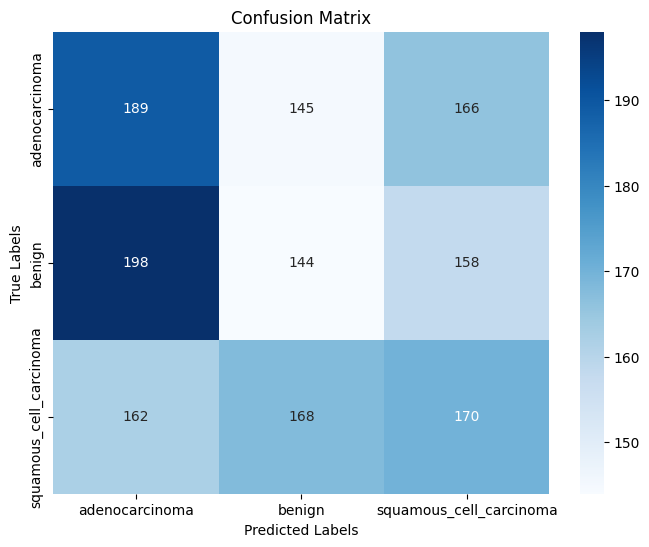

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


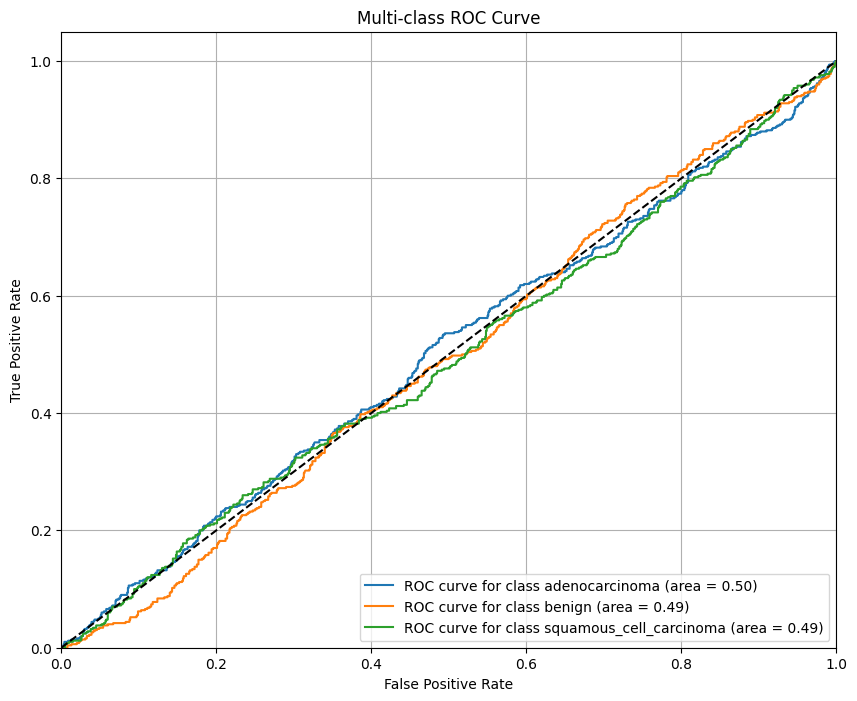

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get number of classes
n_classes = len(class_names)

# Step 1: True labels as one-hot (binarize)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Step 2: Predict class probabilities
# y_pred_probs is already computed: model.predict(test_generator)

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'ROC curve for class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
